time for damping matrix assembly: 0.003594636917114258


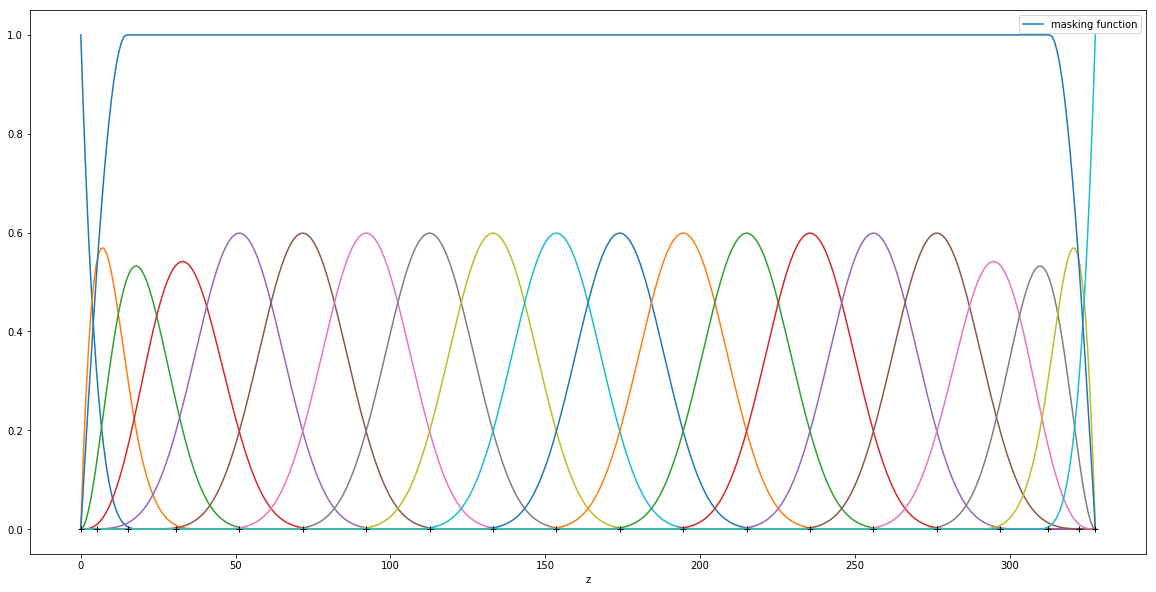

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from Utils_Dipole.createBasis import createBasis
from Utils_Dipole.matrixAssembly import matrixAssembly
import time

Nel = 16
Lz = 327.7
p = 4
bcs = 2
B0 = 1.0
xi = 8.62e-5
Ld = 0.045*Lz
s = 6

def damp(z):
        
    if z <= Ld:
        return np.sin(np.pi*z/(2*Ld))
    elif z >= Lz-Ld:
        return np.sin(np.pi*(Lz-z)/(2*Ld))
    else:
        return 1.0
        
def dz_damp(z):
        
    if z <= Ld:
        return np.cos(np.pi*z/(2*Ld))*np.pi/(2*Ld)
    elif z >= Lz - Ld:
        return -np.cos(np.pi*(Lz-z)/(2*Ld))*np.pi/(2*Ld)
    else:
        return 0.0
    
    
# define backgroud field
def B_background_z(z):
    return B0*(1 + xi*(z - Lz/2)**2)

bsp,Nbase,quad_points,weights = createBasis(Lz,Nel,p,bcs)
M,C,D = matrixAssembly(bsp,p,Nel,weights,quad_points,B_background_z,bcs,damp,dz_damp)
grev = bsp.greville()

f1 = plt.figure()
f1.set_figheight(10)
f1.set_figwidth(20)

nz = 400
y = np.zeros((Nbase,nz),dtype = np.double)
zplot = np.linspace(0,Lz,nz)
for i in range(0,Nbase):
    y[i] = bsp(zplot,i)
    plt.plot(zplot,bsp(zplot,i))
    
da = np.zeros(nz)
for i in range(0,nz):
    da[i] = damp(zplot[i])
    
plt.plot(zplot,da,label = 'masking function')
plt.plot(bsp.greville(),np.zeros(Nbase),'k+')
plt.xlabel('z')
plt.legend()


# ... assemble damping matrix
timea = time.time()
    
gi = np.zeros(Nbase)
Bij = np.zeros((Nbase,Nbase))
    
p_boundary_l = p
p_boundary_r = p + 3
counter = 2
    
# ... assemble left boundary
for ie in range(p+1):
    
    for il in range(p_boundary_l):
        Bij[il,ie] = bsp(grev[il],ie)
            
    p_boundary_l +=1
# ...
    
# ... assemble bulk
for ie in range(p+1,Nbase-p-1):
    
    for il in range(p+2):
        i = il + counter
        Bij[i,ie] = bsp(grev[i],ie)
            
    counter += 1 
# ...
    
# ... assemble right boundary
for ie in range(Nbase-p-1,Nbase):
    
    for il in range(p_boundary_r):
        i = Nbase - p_boundary_r + il
        Bij[i,ie] = bsp(grev[i],ie)
            
    p_boundary_r -=1 
# ...
    
# ... assemble g(x_i)
for i in range(0,Nbase):
    gi[i] = damp(grev[i])
# ...
    
G = np.diag(gi[1:Nbase-1])
Bijinv = np.linalg.inv(Bij[1:Nbase-1,1:Nbase-1])
DAMP_1 = np.dot(np.dot(Bijinv,G),Bij[1:Nbase-1,1:Nbase-1])
DAMP = np.zeros((s*(Nbase-2),s*(Nbase-2)))
    
timeb = time.time()
print('time for damping matrix assembly: ' + str(timeb - timea))